Chris Padgett

Greg Peters

CSCI 4800 Data Science

# Data Exploration

## Problem Statement and Background

Wouldn’t it be great if we could determine what movies are good before we see them? There isn’t a simple formula to follow to make a hit movie that everyone enjoys. Maybe a good movie comes from a good story created by movie writers, or maybe it’s from the actors playing the characters, or the director dictating the scene. It could even be a combination of all of these factors. This has led us to ask the question: Can we predict movie review ratings based on the director, cast or writers of a movie?

Gaining insight into the questions above is not only useful for the movie viewer, but also for the movie creators. Film is a multi billion dollar industry and is one of the most popular forms of entertainment today. Knowing if any of these data points has an impact on movie ratings could allow creators to make better decisions to make better movies for everyone to enjoy.

## The Data Sources

The data we have decided to use for the project is collected from the International Movie Database imdb.com. IMDB is widely used and updated consistently by many contributors giving us confidence that the data will be accurate.

The main data we are interested in for each movie is the critic review score, user review score, writers, directors, and full cast. While we are interested in these data points, other data was taken from the site and might be used as we see fit later in the project. For the list of movies to query from IMDB we used the-numbers.com which is a website that reports information on movie budgets. The list contains over 5,200 movie titles which even after data scrubbing should contain enough data for the machine learning as well as test data for prediction results. Since we scraped the data from IMDB, there will be some cleanup of the data needed up front. Most notably we scraped raw data from two different web pages for each movie in order to get the full cast and writers data needed for our predicion analysis.

The code we used to scrape IMDB uses a python library called Scrapy and is locaed in the *Data Collection* folder in our Github repository. Also located in the directory is an iPython notebook with the steps used to collect the data, as well as the raw data json object files.

## Data Flaws/Weaknesses and Cleaning

### Load and Parse Raw Data

Our raw data that was scraped from imdb.com comes from a main page for each movie as well as a child page that contains the full cast and writers data. As a result, we have data for each movie in two different json files. One file, *imdb_output.json* contains all of the movie data except for the full cast and writers which is stored in *imdb_people.json*. Luckily, IMDB has a unique key for each movie, so joining the data on the *movie_id* will be used and give us high confidence the data is joined correctly. Having this unique key movies also makes it so we know there are no missing or duplicate movies in the dataset.

We will be converting cast and writer people into unique *people_id*s since people can have the same name, but be different people. As with the *movie_id*, IMDB also stores people with a unique *people_id* making this task trivial.

In [1]:
import os
import re
import csv
import json
import locale
import collections

locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

def parse_price(price):
    # eg: u'$237,000,000' --> 237000000
    if not price:
        return 0
    return locale.atoi(re.sub('[^0-9,]', "", price))

def parse_duration(duration_string):
    if not duration_string:
        return 0

    if "min" in duration_string:
        if "h" in duration_string: # eg: "2h 49min"
            s = duration_string.split("h")
            hours = int(s[0])
            if len(s) > 1: # has minute number
                if "min" in s[1]:
                    minutes = int(s[1].strip().split("min")[0])
                else:
                    minutes = 0
            else:
                minutes = 0
            return 60 * hours + minutes
        else: # eg: "169 min"
            return int(duration_string.split('min')[0])
    else:
        if "h" in duration_string: # eg: "2h"
            return int(duration_string.split('h')[0].strip()) * 60
        else:
            return None

def load_unparsed_movie_metadata():
    try:
        with open("Data Collection/imdb_output.json", "r") as f:
            movies = json.load(f)
            return movies
    except:
        print("Cannot load the unparsed movie metadata file!")
        return None
    
def load_unparsed_movie_people():
    try:
        with open("Data Collection/imdb_people.json", "r") as f:
            movie_people = json.load(f)
            return movie_people
    except:
        print("Cannot load the unparsed movie people metadata file!")
        return None

def parse_genres(genres):
    if not genres:
        return None
    return "|".join([g.strip() for g in sorted(genres)])

def parse_plot_keywords(words):
    if not words:
        return None
    return "|".join([w.strip() for w in sorted(words)])

def parse_cast_info(cast):
    if not cast:
        return None
    return "|".join([c['name_id'].strip() for c in sorted(cast)])

def parse_writer_info(writers):
    if not writers:
        return None
    return "|".join([w['name_id'].strip() for w in sorted(writers)])

def parse_aspect_ratio(ratio_string):
    if not ratio_string:
        return None
    if ":" in ratio_string:
        return float(ratio_string.split(":")[0].strip())
    else:
        return float(re.search('[0-9,.]+', ratio_string).group())

def parse_one_movie_metadata(movie, movie_people):
    if not movie:
        return None

    parsed_movie = {}

    parsed_movie['movie_imdb_link'] = movie['movie_imdb_link']
    parsed_movie['imdb_id'] = movie['imdb_id']
    parsed_movie['movie_title'] = movie['movie_title'].encode('utf-8')
    parsed_movie['num_voted_users'] = movie['num_voted_users']
    parsed_movie['plot_keywords'] = parse_plot_keywords(movie['plot_keywords'])
    parsed_movie['num_user_for_reviews'] = movie['num_user_for_reviews']
    parsed_movie['language'] = None if movie['language'] is None or len(movie['language']) == 0 else movie['language'][0] # choose the first language
    parsed_movie['country'] = None if movie['country'] is None or len(movie['country']) == 0 else movie['country'][0] # choose 1st country
    parsed_movie['genres'] = parse_genres(movie['genres'])
    parsed_movie['color'] = None if movie['color'] is None or len(movie['color']) == 0 else movie['color'][0]
    parsed_movie['gross'] = None if movie['gross'] is None or len(movie['gross']) == 0 else parse_price(movie['gross'][0].strip())
    parsed_movie['content_rating'] = None if movie['content_rating'] is None or len(movie['content_rating']) == 0 else movie['content_rating'][0].strip()
    parsed_movie['budget'] = None if movie['budget'] is None or len(movie['budget']) == 0 else parse_price(movie['budget'][0].strip())
    parsed_movie['title_year'] = None if movie['title_year'] is None else int(movie['title_year'])
    parsed_movie['storyline'] = None if movie['storyline'] is None else movie['storyline'].strip().encode('utf-8')
    parsed_movie['user_review_score'] = None if movie['user_review_score'] is None or len(movie['user_review_score']) == 0 else float(movie['user_review_score'][0].strip())
    parsed_movie['critic_review_score'] = None if movie['critic_review_score'] is None or len(movie['critic_review_score']) == 0 else float(movie['critic_review_score'][0].strip())
    parsed_movie['aspect_ratio'] = parse_aspect_ratio(movie['aspect_ratio'])
    parsed_movie['num_critic_for_reviews'] = None if movie['num_critic_for_reviews'] is None else movie['num_critic_for_reviews']

    # parse movie duration
    duration = movie['duration']
    if not duration:
        parsed_movie['duration'] = None
    else:
        if len(duration) == 1:
            parsed_movie['duration'] = parse_duration(duration[0].strip())
        else:
            parsed_movie['duration'] = parse_duration(duration[-1].strip())
    
    # parse director info
    director_info = movie['director_info']
    if not director_info:
        parsed_movie['director_name_id'] = None
    else:
        parsed_movie['director_name_id'] = director_info['name_id'].encode('utf-8')
        
    # parse cast and writer info
    for movie_crew in movie_people:
        if parsed_movie['imdb_id'] == movie_crew['imdb_id']:
            parsed_movie['cast_info'] = parse_cast_info(movie_crew['cast_info'])
            parsed_movie['writer_info'] = parse_writer_info(movie_crew['writer_info'])
            break

    return parsed_movie

def parse_all_movies():
    movies = load_unparsed_movie_metadata()
    total_movies = len(movies)
    print("{} movie metadata were loaded!".format(total_movies))

    movie_people = load_unparsed_movie_people()
    total_movie_people = len(movie_people)
    print("{} movie people data were loaded!".format(total_movie_people))
    
    with open("Datasets/movie_metadata_all.csv", "w") as f:
        header_was_written = False
        for i, movie in enumerate(movies):
            parsed_movie = parse_one_movie_metadata(movie, movie_people)
            w = csv.DictWriter(f, parsed_movie.keys())
            if not header_was_written:
                w.writeheader()
                header_was_written = True

            w.writerow(parsed_movie)
            if (i+1) % 500 == 0 or i+1 == total_movies:
                print("Processed {} of {} movie metadata...".format(i+1, total_movies))
            
    print("Movie metadata processing complete!")
    
parse_all_movies()

5221 movie metadata were loaded!
5221 movie people data were loaded!
Processed 500 of 5221 movie metadata...
Processed 1000 of 5221 movie metadata...
Processed 1500 of 5221 movie metadata...
Processed 2000 of 5221 movie metadata...
Processed 2500 of 5221 movie metadata...
Processed 3000 of 5221 movie metadata...
Processed 3500 of 5221 movie metadata...
Processed 4000 of 5221 movie metadata...
Processed 4500 of 5221 movie metadata...
Processed 5000 of 5221 movie metadata...
Processed 5221 of 5221 movie metadata...
Movie metadata processing complete!


### Data Cleaning

Now that we have parsed the data we will need to remove any movies that are missing data for the fields in which we are interested. Namely, we will need to remove any movie that is missing the cast info or writer info as they are they focus of the machine learning.

In [2]:
import pandas as pd

dirty_movie_data = pd.read_csv("Datasets/movie_metadata_all.csv")
required_fields = {'cast_info': 0, 'writer_info': 0}

def clean_movies(dirty_movie_data, required_fields):
    missing_data = []
    for i, movie in dirty_movie_data.iterrows():
        for req_field in required_fields:
            if pd.isnull(movie[req_field]):
                missing_data.append(movie['imdb_id'])
                required_fields[req_field] = required_fields[req_field] + 1
            
    for req_field in required_fields:
        print('Movies missing {}: {}'.format(req_field, required_fields[req_field]))
    
    missing_data = set(missing_data)
    print('Removing movies missing data...')
    return dirty_movie_data[~dirty_movie_data['imdb_id'].isin(missing_data)]

clean_movie_data = clean_movies(dirty_movie_data, required_fields)
print('Movies remaining: {}'.format(len(clean_movie_data)))

Movies missing cast_info: 28
Movies missing writer_info: 335
Removing movies missing data...
Movies remaining: 4886


### Create Critic and User Datasets

Since we are investigating two different ratings, critic and user, we will create two data sets; one for each. When making these datasets we will also need to remove movies that are missing the critic rating or user rating in the respective datasets. Also, if the number of contributed critic ratings or user ratings is too low we will also remove it. This is aimed at making the data more accurate by having a better sample size for the ratings.

In [3]:
min_required_critic_reviews = 10
min_required_user_reviews = 100

def create_critic_dataset(clean_movie_data, min_required_critic_reviews):
    dirty_critic_data = {'critic_review_score': [], 'num_critic_for_reviews': []}
    for i, movie in clean_movie_data.iterrows():
        if pd.isnull(movie['critic_review_score']):
            dirty_critic_data['critic_review_score'].append(movie['imdb_id'])
            
        if pd.isnull(movie['num_critic_for_reviews']) or movie['num_critic_for_reviews'] < min_required_critic_reviews:
            dirty_critic_data['num_critic_for_reviews'].append(movie['imdb_id'])
            
    print('Critic Dataset - missing critic_review_score: {}'.format(len(dirty_critic_data['critic_review_score'])))
    print('Critic Dataset - not enough reviews (<{}): {}'.format(min_required_critic_reviews, len(dirty_critic_data['num_critic_for_reviews'])))
    
    critic_removal_list = set(dirty_critic_data['critic_review_score'] + dirty_critic_data['num_critic_for_reviews'])
    print('Removing movies from critic dataset...')
    return clean_movie_data[~clean_movie_data['imdb_id'].isin(critic_removal_list)]

def create_user_dataset(clean_movie_data, min_required_user_reviews):
    dirty_user_data = {'user_review_score': [], 'num_voted_users': []}
    for i, movie in clean_movie_data.iterrows():
        if pd.isnull(movie['user_review_score']):
            dirty_user_data['user_review_score'].append(movie['imdb_id'])
            
        if pd.isnull(movie['num_voted_users']) or movie['num_voted_users'] < min_required_user_reviews:
            dirty_user_data['num_voted_users'].append(movie['imdb_id'])
            
    print('User Dataset - missing user_review_score: {}'.format(len(dirty_user_data['user_review_score'])))
    print('User Dataset - not enough reviews (<{}): {}'.format(min_required_user_reviews, len(dirty_user_data['num_voted_users'])))
    
    user_removal_list = set(dirty_user_data['user_review_score'] + dirty_user_data['num_voted_users'])
    print('Removing movies from user dataset...')
    return clean_movie_data[~clean_movie_data['imdb_id'].isin(user_removal_list)]
    
full_critic_dataset = create_critic_dataset(clean_movie_data, min_required_critic_reviews)
print('Full Critic Dataset contains {} movies\n'.format(len(full_critic_dataset)))
full_critic_dataset.to_csv('Datasets/full_critic_dataset.csv')

full_user_dataset = create_user_dataset(clean_movie_data, min_required_user_reviews)
print('Full User Dataset contains {} movies'.format(len(full_user_dataset)))
full_user_dataset.to_csv('Datasets/full_user_dataset.csv')

Critic Dataset - missing critic_review_score: 1144
Critic Dataset - not enough reviews (<10): 303
Removing movies from critic dataset...
Full Critic Dataset contains 3717 movies

User Dataset - missing user_review_score: 39
User Dataset - not enough reviews (<100): 100
Removing movies from user dataset...
Full User Dataset contains 4786 movies


### Divide Datasets into Learn and Test Data

We will be dividing the datasets into Learning and Test Datasets. The Learning Dataset will be used in the machine learning prediction algorithm and the Test Dataset will be used to test the prediction algorithm guess for accuracy. 90% of the full datasets will be used in the Learning Dataset and 10% for the Test Dataset.

In [4]:
def divide_dataset_learn_test(dataset_path, learn_path, test_path, learn_mod):
    ds = pd.read_csv(dataset_path)
    print('{} contains {} movies'.format(dataset_path, len(ds)))
    
    learn_ds = pd.DataFrame([row for i, row in ds.iterrows() if (i % learn_mod) != 0])
    test_ds = pd.DataFrame([row for i, row in ds.iterrows() if (i % learn_mod) == 0])
                    
    learn_ds.to_csv(learn_path)
    test_ds.to_csv(test_path)
            
learn_mod = 10
divide_dataset_learn_test('Datasets/full_critic_dataset.csv', 'Datasets/learn_critic_dataset.csv', 'Datasets/test_critic_dataset.csv', learn_mod)
learn_critic_dataset = pd.read_csv('Datasets/learn_critic_dataset.csv')
test_critic_dataset = pd.read_csv('Datasets/test_critic_dataset.csv')
print('Critic Learning Dataset size: {}'.format(len(learn_critic_dataset)))
print('Critic Testing Dataset size: {}\n'.format(len(test_critic_dataset)))

divide_dataset_learn_test('Datasets/full_user_dataset.csv', 'Datasets/learn_user_dataset.csv', 'Datasets/test_user_dataset.csv', learn_mod)
learn_user_dataset = pd.read_csv('Datasets/learn_user_dataset.csv')
test_user_dataset = pd.read_csv('Datasets/test_user_dataset.csv')
print('User Learning Dataset size: {}'.format(len(learn_user_dataset)))
print('User Testing Dataset size: {}'.format(len(test_user_dataset)))

Datasets/full_critic_dataset.csv contains 3717 movies
Critic Learning Dataset size: 3345
Critic Testing Dataset size: 372

Datasets/full_user_dataset.csv contains 4786 movies
User Learning Dataset size: 4307
User Testing Dataset size: 479


## Analyzing The Data
Now that we have captured data, we need to get an idea of what we have.  First we read in the file from it's location into a list.  Then we create a dictionary mapping for easy access of each section of data.

In [5]:
%matplotlib inline
import csv
import numpy as np
import pylab
import pandas as pd

user_movdata = pd.read_csv('Datasets/full_user_dataset.csv')
critic_movdata = pd.read_csv('Datasets/full_critic_dataset.csv')

###  Function to get a column of data
This function allows us to get a column of data from our datasets as a list.

In [6]:
def getcol(colname, dataset):
    return [x[colname] for i, x in dataset.iterrows()]

###  Histogram of User Reviews on a 1-10 scale
All user reviews from our data are put into a histogram showing the data skew toward the right for a hire ratings among users.


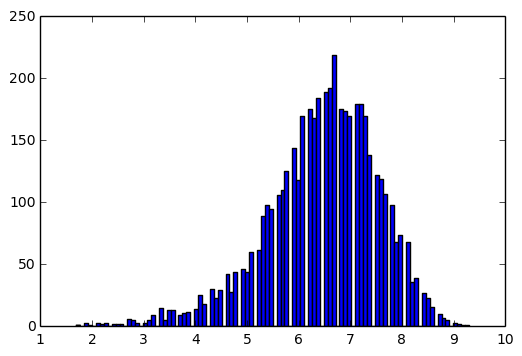

In [7]:
user_rate = getcol('user_review_score', user_movdata)
user_rate = [float(i) for i in user_rate]

# Display user ratings for each movie on 1 to 10 rating scale
h1 = pylab.hist(user_rate, bins = 100)

### Histogram of all critic reviews on a 1-10 scale
All critic reviews are put into a histogram showing resulting in a more balanced distribution among critics.

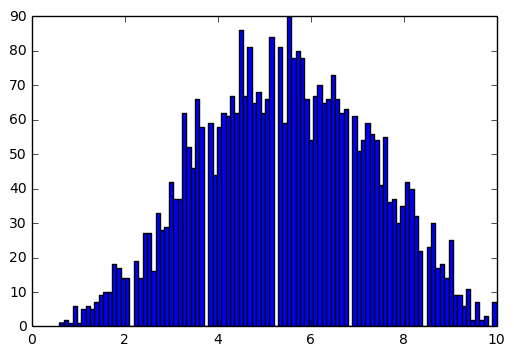

In [8]:
#Display histogram of all critic reviews.  Reviews are on a 1-100 scale, so I have divided by 10 to match user reviews.
critic_rate = getcol('critic_review_score', critic_movdata)
critic_rate = [(float(i)/10) for i in critic_rate]

h2 = pylab.hist(critic_rate, bins = 100)

### Bar Graph of Critic Reviews
This graphs shows the overall number of critic reviews for each movie we have data for.

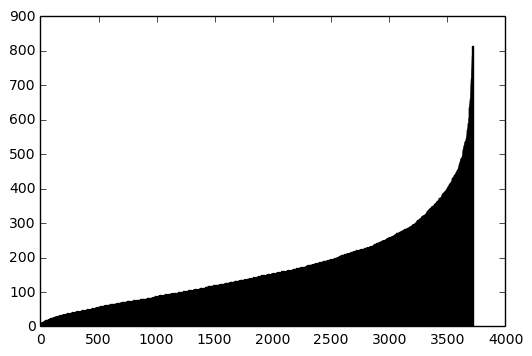

In [9]:
# Number of critic review per movie
critic_total = getcol('num_critic_for_reviews', critic_movdata)
critic_total = [float(i) for i in critic_total]
critic_total.sort()

N = len(critic_total)
x = range(N)
h3 = pylab.bar(x, critic_total, .5)

### Bar Graph of User Reviews
This graph shows the overall number of user reviews for each movie we have data for.  The number of user reviews is clearly much higher than critic reviews

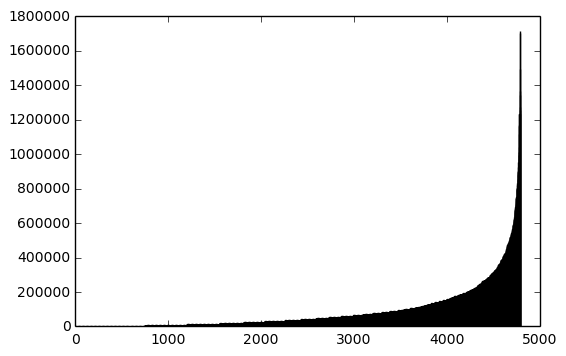

In [10]:
#Number of user reviews for each movie
user_total = getcol('num_voted_users', user_movdata)
user_total= [float(i) for i in user_total]
user_total.sort()

N = len(user_total)
x = range(N)
h4 = pylab.bar(x, user_total, .5)

### Bar Graph of Writers for User Reviews
This creates a graph of how many writers were given credit for moview with user reviews. 

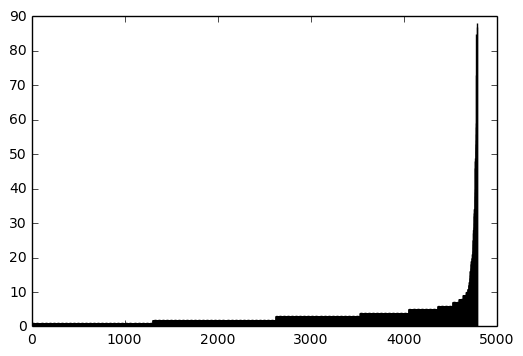

In [11]:
user_writer_count = getcol('writer_info', user_movdata)
user_writers = list()
i = 0
while i < len(user_writer_count):
    user_writers.append((user_writer_count[i].count('|') + 1))   #add 1 to account that '|' is between actors only
    i = i + 1

user_writers.sort()    

N = len(user_writers)
x = range(N)
h5 = pylab.bar(x, user_writers, .5)

### Bar Graph of Writers for Critic Reviews
This creates a graph of how many writers were given credit for moview with critic reviews. 

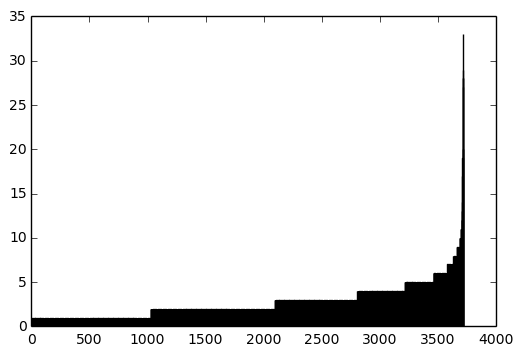

In [12]:
critic_writer_count = getcol('writer_info', critic_movdata)
critic_writers = list()
j = 0
while j < len(critic_writer_count):
    critic_writers.append((critic_writer_count[j].count('|') + 1))   #add 1 to account that '|' is between actors only
    j = j + 1

critic_writers.sort()
    
M = len(critic_writers)
y = range(M)
h6 = pylab.bar(y, critic_writers, .5)

### Bar Graph of Actors for User Reviews
This creates a graph of how many actors are given credit for movies with user reviews. 

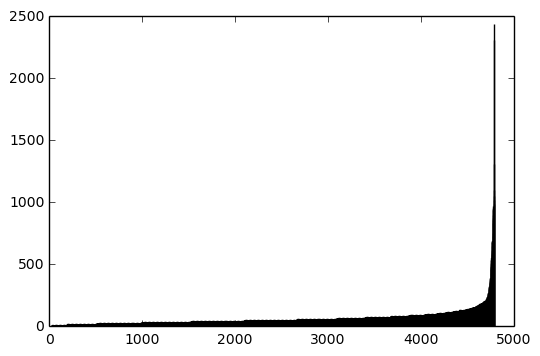

In [13]:
user_actor_count = getcol('cast_info', user_movdata)
user_actors = list()
i = 0
while i < len(user_actor_count):
    user_actors.append((user_actor_count[i].count('|') + 1))   #add 1 to account that '|' is between actors only
    i = i + 1

user_actors.sort()
    
N = len(user_actors)
x = range(N)
h7 = pylab.bar(x, user_actors, .5)

### Bar Graph of Actors for Critic Reviews
This creates a graph of how many actors are given credit for movies with critic reviews. 

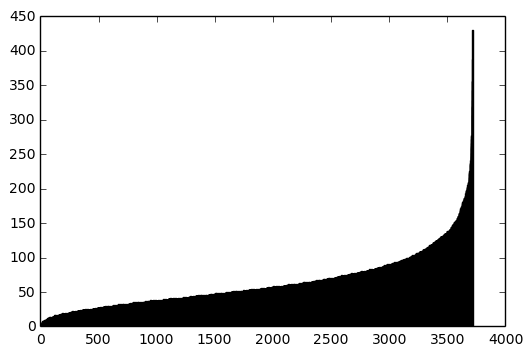

In [14]:
critic_actor_count = getcol('cast_info', critic_movdata)
critic_actors = list()
j = 0
while j < len(critic_actor_count):
    critic_actors.append((critic_actor_count[j].count('|') + 1))   #add 1 to account that '|' is between actors only
    j = j + 1

critic_actors.sort()
    
M = len(critic_actors)
y = range(M)
h8 = pylab.bar(y, critic_actors, .5)


## Surprises

It was surprising that the movie data was missing critic reviews for almost 30% of the movies. Since critics are paid to review movies we guessed that more of the movies would have critic ratings. We guess that there are less critic ratings because people are interested in new movie review rather than old movies.

Another surprise was the distribution of user and critic reviews for the movies.  Users appeared to enjoy movies as a whole more often than critics did.  We were also surprised by the symetrical distribution of critic reviews.

## Next Steps, any Obstacles

Our next step will be to analyze our data and to decide on thresholds based on user and critic reviews to determine a "good" movie from a "bad" movie.  This part may involve throwing out a small amount of data that may be missing certain information we will need, or that may not contain enough information.  We will also be looking for patterns in our data that will help us as we try to create an alogorithm that can predict great movies.